# Neighbour Extraction using Gram Matrices

---

In [1]:
import sys
print(sys.executable)
print(sys.version)

/home/kshitij98/getNeighbours/venv/bin/python3
3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]


In [2]:
from ipynb.fs.full.Helper import getDataLoader, getNames, dist
from ipynb.fs.full.GramMatrix import convertModel, GramMatrixLayer
from ipynb.fs.full.LabelDataset import createDirectories

import torch
import torch.nn as nn

%matplotlib inline

---

## Feature Extraction

In [ ]:
loader = getDataLoader('/scratch/bam_subset_2_0_labeled', batch_size=4, shuffle=False, num_workers=4, testing=False)

In [ ]:
import torchvision.models as models
vgg19 = models.vgg19(pretrained=True)

In [ ]:
gramMatrixLayers = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
gramMatrixWeights = [1, 1, 1, 1, 1]
vgg19, model, gram_matrices = convertModel(vgg19, gramMatrixLayers, gramMatrixWeights, testing=False)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model.eval()
model.to(device)

In [ ]:
dataIter = iter(loader)

(data, classes), names = dataIter.next()
data = data.cuda()
out = model(data)
G = []
for layer in gram_matrices:
    G.append(layer.gramMatrix)
G = torch.cat(G, 1)

a, D = G.size()

print(D)

Find a ‘safe’ number of components to randomly project to

The distortion introduced by a random projection p only changes the distance between two points by a factor (1 +- eps) in an euclidean space with good probability.

In [ ]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

# TODO: Remove hardcoded dataset size
K = johnson_lindenstrauss_min_dim(40474, eps=0.3)

print(K)

In [ ]:
from sklearn.random_projection import gaussian_random_matrix

RPM = gaussian_random_matrix(K, D)
RPM = RPM.transpose()
print(RPM.shape)

In [ ]:
import os

if not os.path.exists('/scratch/kshitij98'):
    print("Creating", '/scratch/kshitij98')
    os.makedirs('/scratch/kshitij98')

RPM = torch.from_numpy(RPM)
RPM = RPM.cuda()
RPM = RPM.float()
print(RPM.shape)

torch.save(RPM, "/scratch/kshitij98/rpm")

In [ ]:
import time

createDirectories('/scratch/bam_subset_2_0_features/')

dataIter = iter(loader)
t = time.time()

# TODO: Remove hardcoded dataset size
i = 1
while i <= 30250:
    (data, classes), names = dataIter.next()
    data = data.cuda()
    out = model(data)
    G = []
    for layer in gram_matrices:
        G.append(layer.gramMatrix)
    G = torch.cat(G, 1)
#     for j, gm in enumerate(G):
#         print(names[j])
#     break
#         torch.save(gm, names[j].replace('imdb_dataset', 'imdb_dataset_features'))
    G = torch.mm(G, RPM)
    for j, gm in enumerate(G):
#         print(names[j])
        torch.save(gm, names[j].replace('bam_subset_2_0_labeled', 'bam_subset_2_0_features'))
    print(i, "\tETA: ", ((time.time() - t) / ((i) * 4)) * (121000 - ((i) * 4)) * (1 / 60), "minutes", end='\r')
    i += 1
    

---

## Get Neighbours

In [ ]:
import time

t = time.time()

names = getNames('/scratch/bam_subset_2_0_features/')
X = []
for i, fileName in enumerate(names):
    X.append(torch.load(fileName))
    print("ETA: ", (len(names) - i - 1) * ((time.time() - t) / (i+1)), end='\r')
X = torch.stack(X, 0)
print(X.shape)

In [ ]:
createDirectories('/scratch/bam_subset_2_0_top_neighbours/')
createDirectories('/scratch/bam_subset_2_0_bottom_neighbours/')

In [ ]:
# DO NOT USE
# Negation of MSE

import torch

C = 0.25 * torch.ones(1)
C = C.cuda()

def bDist(n1, n2, C):
    assert(n1.size(0) == 1)

    s1 = n1.size(0)
    s2 = n2.size(0)
    d = n1.size(1)
    
    n1 = n1.expand(s2, d)
    C = C.expand(s2, d)
    n2 = torch.sum((C - torch.min(torch.abs(torch.sub(n1, n2)), C)) ** 4, 1)

    return n2

if __name__ == '__main__':
    A = torch.ones(1, 10)
    B = 1.5* torch.ones(7, 10)
    A = A.cuda()
    B = B.cuda()
    print(bDist(A, B, C))

In [ ]:
# import numpy as np
# # from ipynb.fs.full.Helper import bDist


# k = 15
# t = time.time()
# names = getNames('/scratch/bam_subset_2_0_features/')



# for i, source in enumerate(X):
# #     if i < 25000:
# #         continue
    
# #     if i > 25000 + 200:
# #         break
    
#     source = torch.unsqueeze(source, 0)

# #     d = dist(source, X)
# #     d, indices = d.sort()

#     bD = bDist(source, X, C)
#     bD, bIndices = bD.sort()

# #     topIds = indices[0, 1:k+1]
#     # Note: Negative slicing is not supported
#     bottomIds = bIndices[0:k]

# #     top = []
# #     for idx in topIds:
# # #         print(idx)
# #         top.append(names[idx].replace('bam_subset_2_0_features', 'bam_subset_2_0_labeled'))
# #     top = np.asarray(top)
    
#     bottom = []
#     for idx in bottomIds:
#         bottom.append(names[idx])
#     bottom = np.asarray(bottom)
    
# #     np.save(names[i].replace('bam_subset_2_0_features', 'bam_subset_2_0_top_neighbours'), top)
#     np.save(names[i].replace('bam_subset_2_0_features', 'bam_subset_2_0_bottom_neighbours'), bottom)

#     print("ETA: ", (len(X) - i - 1) * ((time.time() - t) / (i+1)) * (1 / 60), end='\r')

In [5]:
import pickle

fileName = '/scratch/kshitij98/cluster1-1-1-1-1_7.pkl'
kmeans = pickle.load(open(fileName, 'rb'))

In [23]:
centers = torch.from_numpy(kmeans.cluster_centers_)
centers = centers.float().cuda()
print(type(centers))

<class 'torch.Tensor'>


In [17]:
print(type(torch.unsqueeze(X[0], 0)))

<class 'torch.Tensor'>


In [40]:
def getFarthestCluster(source):
    maxDist = None
    farthestCluster = None
    distances = dist(source, centers)
    distances = torch.squeeze(distances, 0)
    for i, d in enumerate(distances):
        if maxDist is None or d > maxDist:
            farthestCluster = i
            maxDist = d
#     print(farthestCluster, maxDist)
    return farthestCluster
    
if __name__ == '__main__':
    getFarthestCluster(torch.unsqueeze(X[0], 0))

In [50]:
import random

sampleIdx = list(range(0, X.shape[0]))
print(len(sampleIdx))
print(sampleIdx[0])
random.shuffle(sampleIdx)
print(sampleIdx[0])

121000
0
94963


In [ ]:
import numpy as np

k = 15
t = time.time()

# Scale the dataset
# X = X ** 0.8

N = 100

for i, sample in enumerate(sampleIdx):
    source = torch.unsqueeze(X[sample], 0)

    d = dist(source, X)
    d, indices = d.sort()

    topIds = indices[0, 1:k+1]
    # # Note: Negative slicing is not supported, Need to reverse
    farthestCluster = getFarthestCluster(source)
    
    bottomIds = []
    cnt = 0
    for idx in reversed(indices[0]):
        if kmeans.labels_[idx] == farthestCluster:
            bottomIds.append(idx)
            cnt += 1
            if cnt == k:
                break
    
    top = []
    for idx in topIds:
        top.append(names[idx].replace('bam_subset_2_0_features', 'bam_subset_2_0_labeled'))
    top = np.asarray(top)
    
    bottom = []
    for idx in bottomIds:
        bottom.append(names[idx].replace('bam_subset_2_0_features', 'bam_subset_2_0_labeled'))
    bottom = np.asarray(bottom)
    
    np.save(names[i].replace('bam_subset_2_0_features', 'bam_subset_2_0_top_neighbours'), top)
    np.save(names[i].replace('bam_subset_2_0_features', 'bam_subset_2_0_bottom_neighbours'), bottom)

    print("ETA: ", (N - i - 1) * ((time.time() - t) / (i+1)), end='\r')
    
    if i == N:
        break

In [ ]:
A = torch.rand(3, 3)
print(A)
print(A**0.8)
print(A*)

---

## Statistics

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

names = getNames('/scratch/bam_subset_2_0_top_neighbours/', shuffle=True)
bNames = getNames('/scratch/bam_subset_2_0_bottom_neighbours/', shuffle=True)

def showImages(images):
    fig = plt.figure(figsize=(32, 32))
    columns = 5
    rows = 4
    for i in range(1, len(images) + 1):
        img = images[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()

idx = 0
def showNeighbours(index = None):
    global idx
    if index is not None:
        idx = index
    nbs = np.load(names[idx])
    bNbs = np.load(bNames[idx])
    images = []
    nImages = []
    print(names[idx])
    images.append(Image.open(names[idx].replace('_top_neighbours', '_labeled').replace('.npy', '')))
    nImages.append(Image.open(bNames[idx].replace('_bottom_neighbours', '_labeled').replace('.npy', '')))
    for nb in nbs:
#         print("NB", nb)
#         nb = nb.replace('bam_subset_2_0', 'bam_subset_2_0_labeled')
        images.append(Image.open(nb))
    for nb in bNbs:
#         print("NB", nb)
#         nb = nb.replace('bam_subset_2_0_features', 'bam_subset_2_0_labeled')
        nImages.append(Image.open(nb))
    showImages(images)
    showImages(nImages)
    idx += 1


#### Qualitatively test results

/scratch/bam_subset_2_0_top_neighbours/7/153887323_23150305.jpg.npy


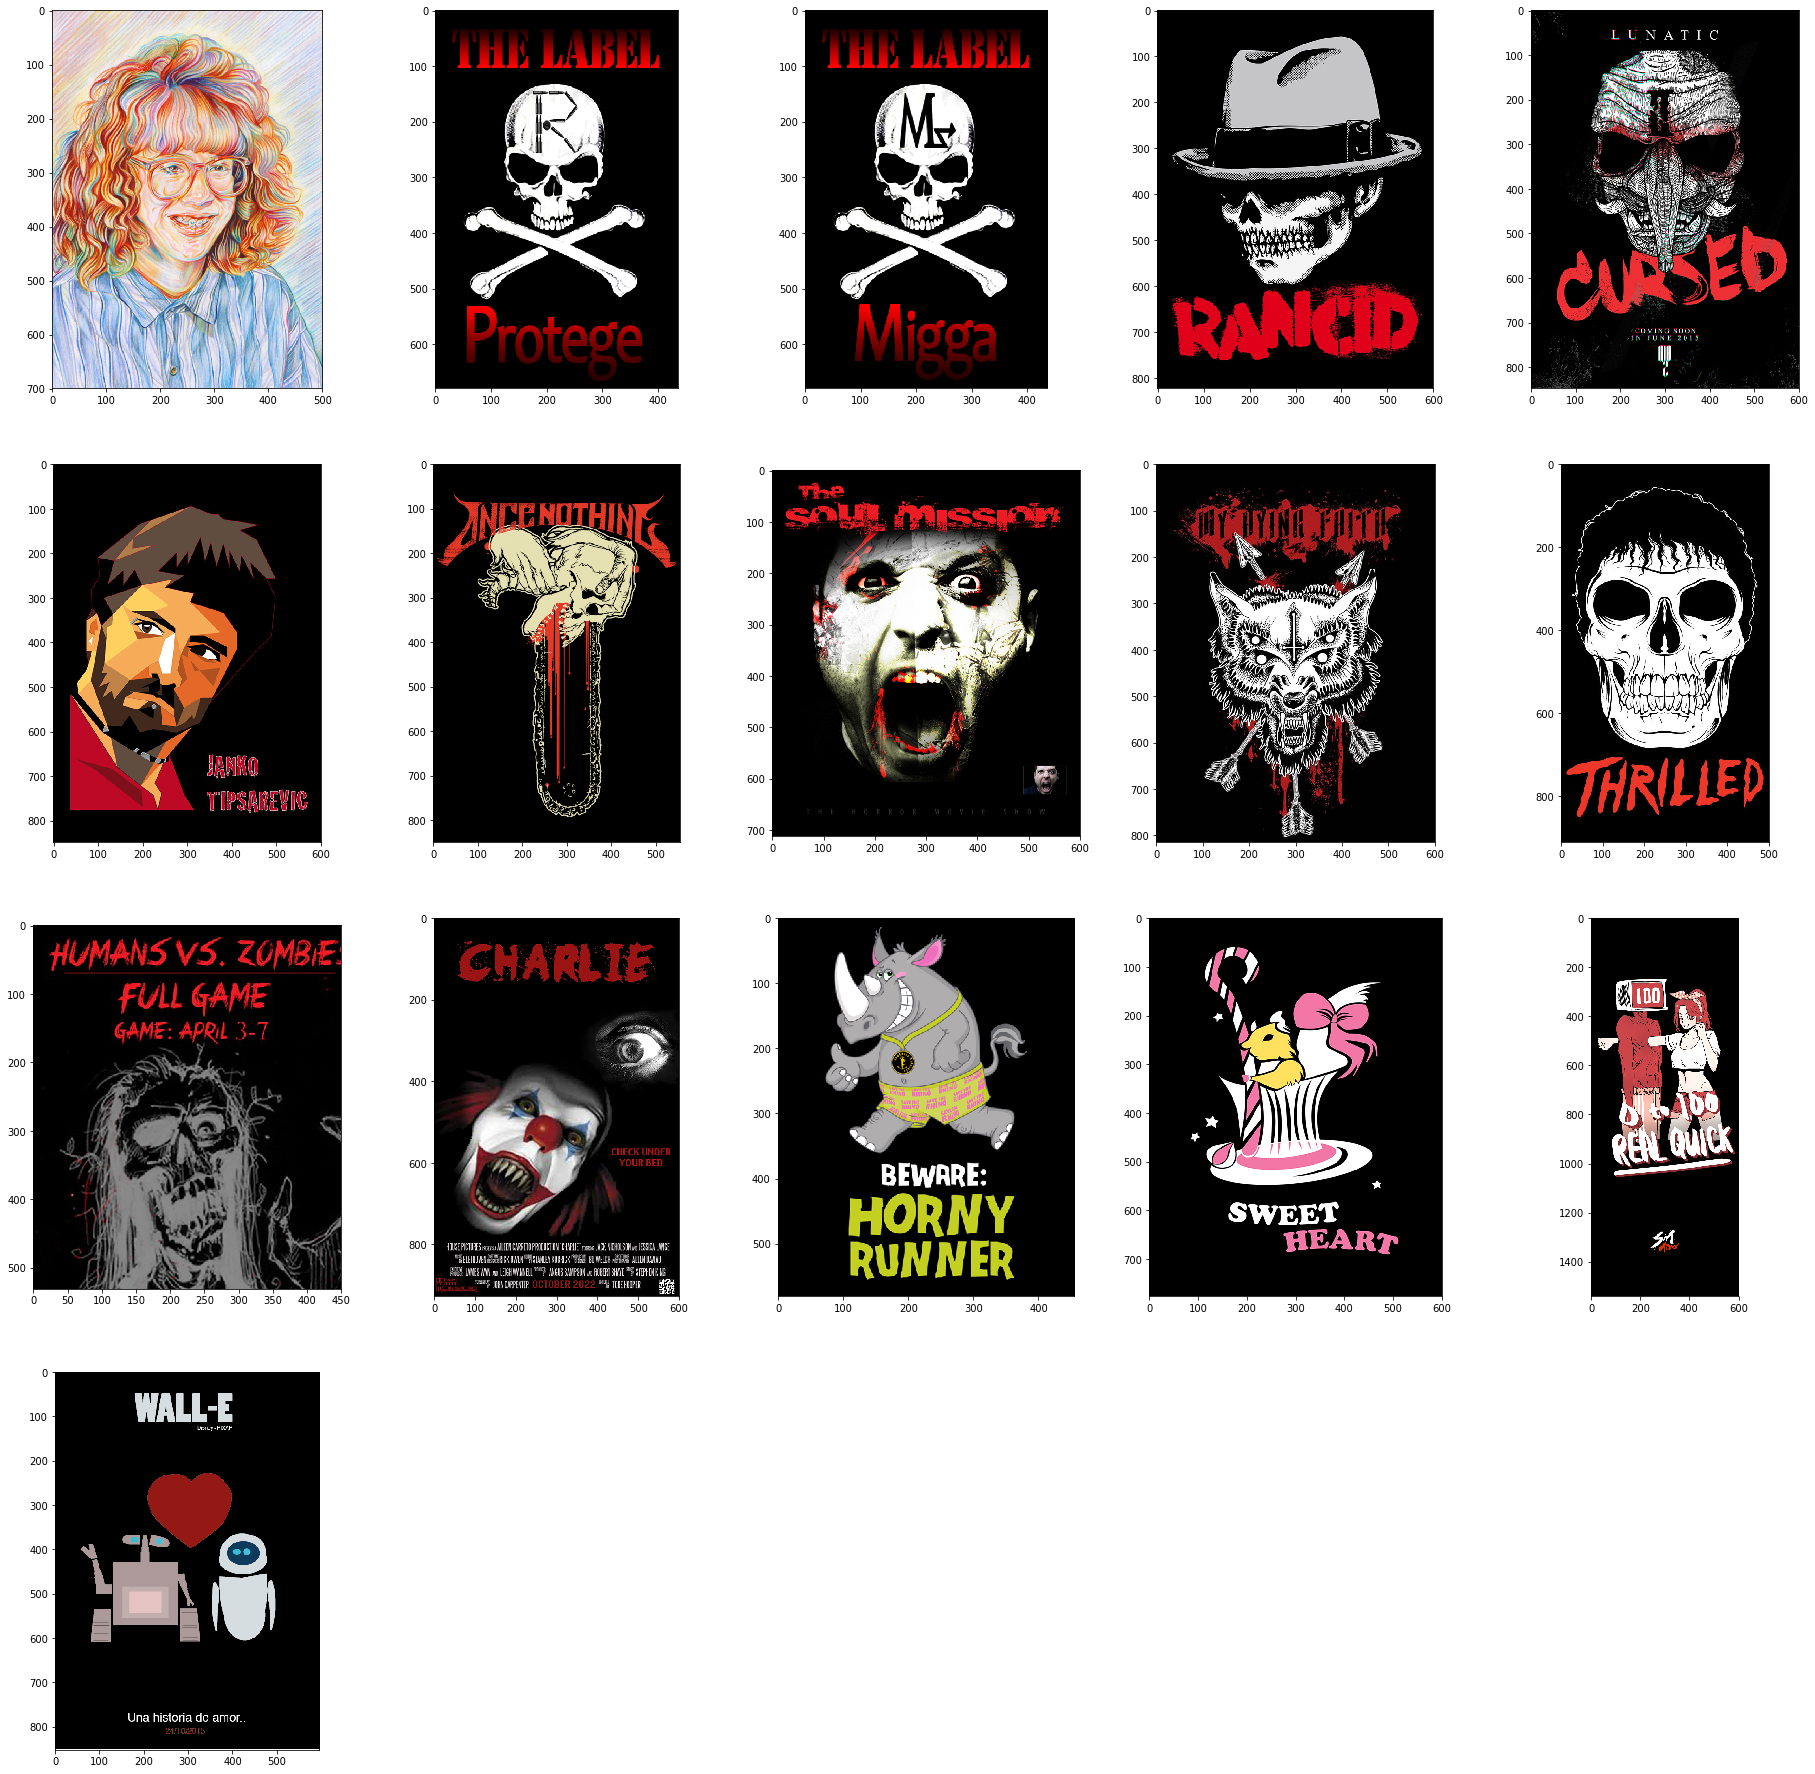

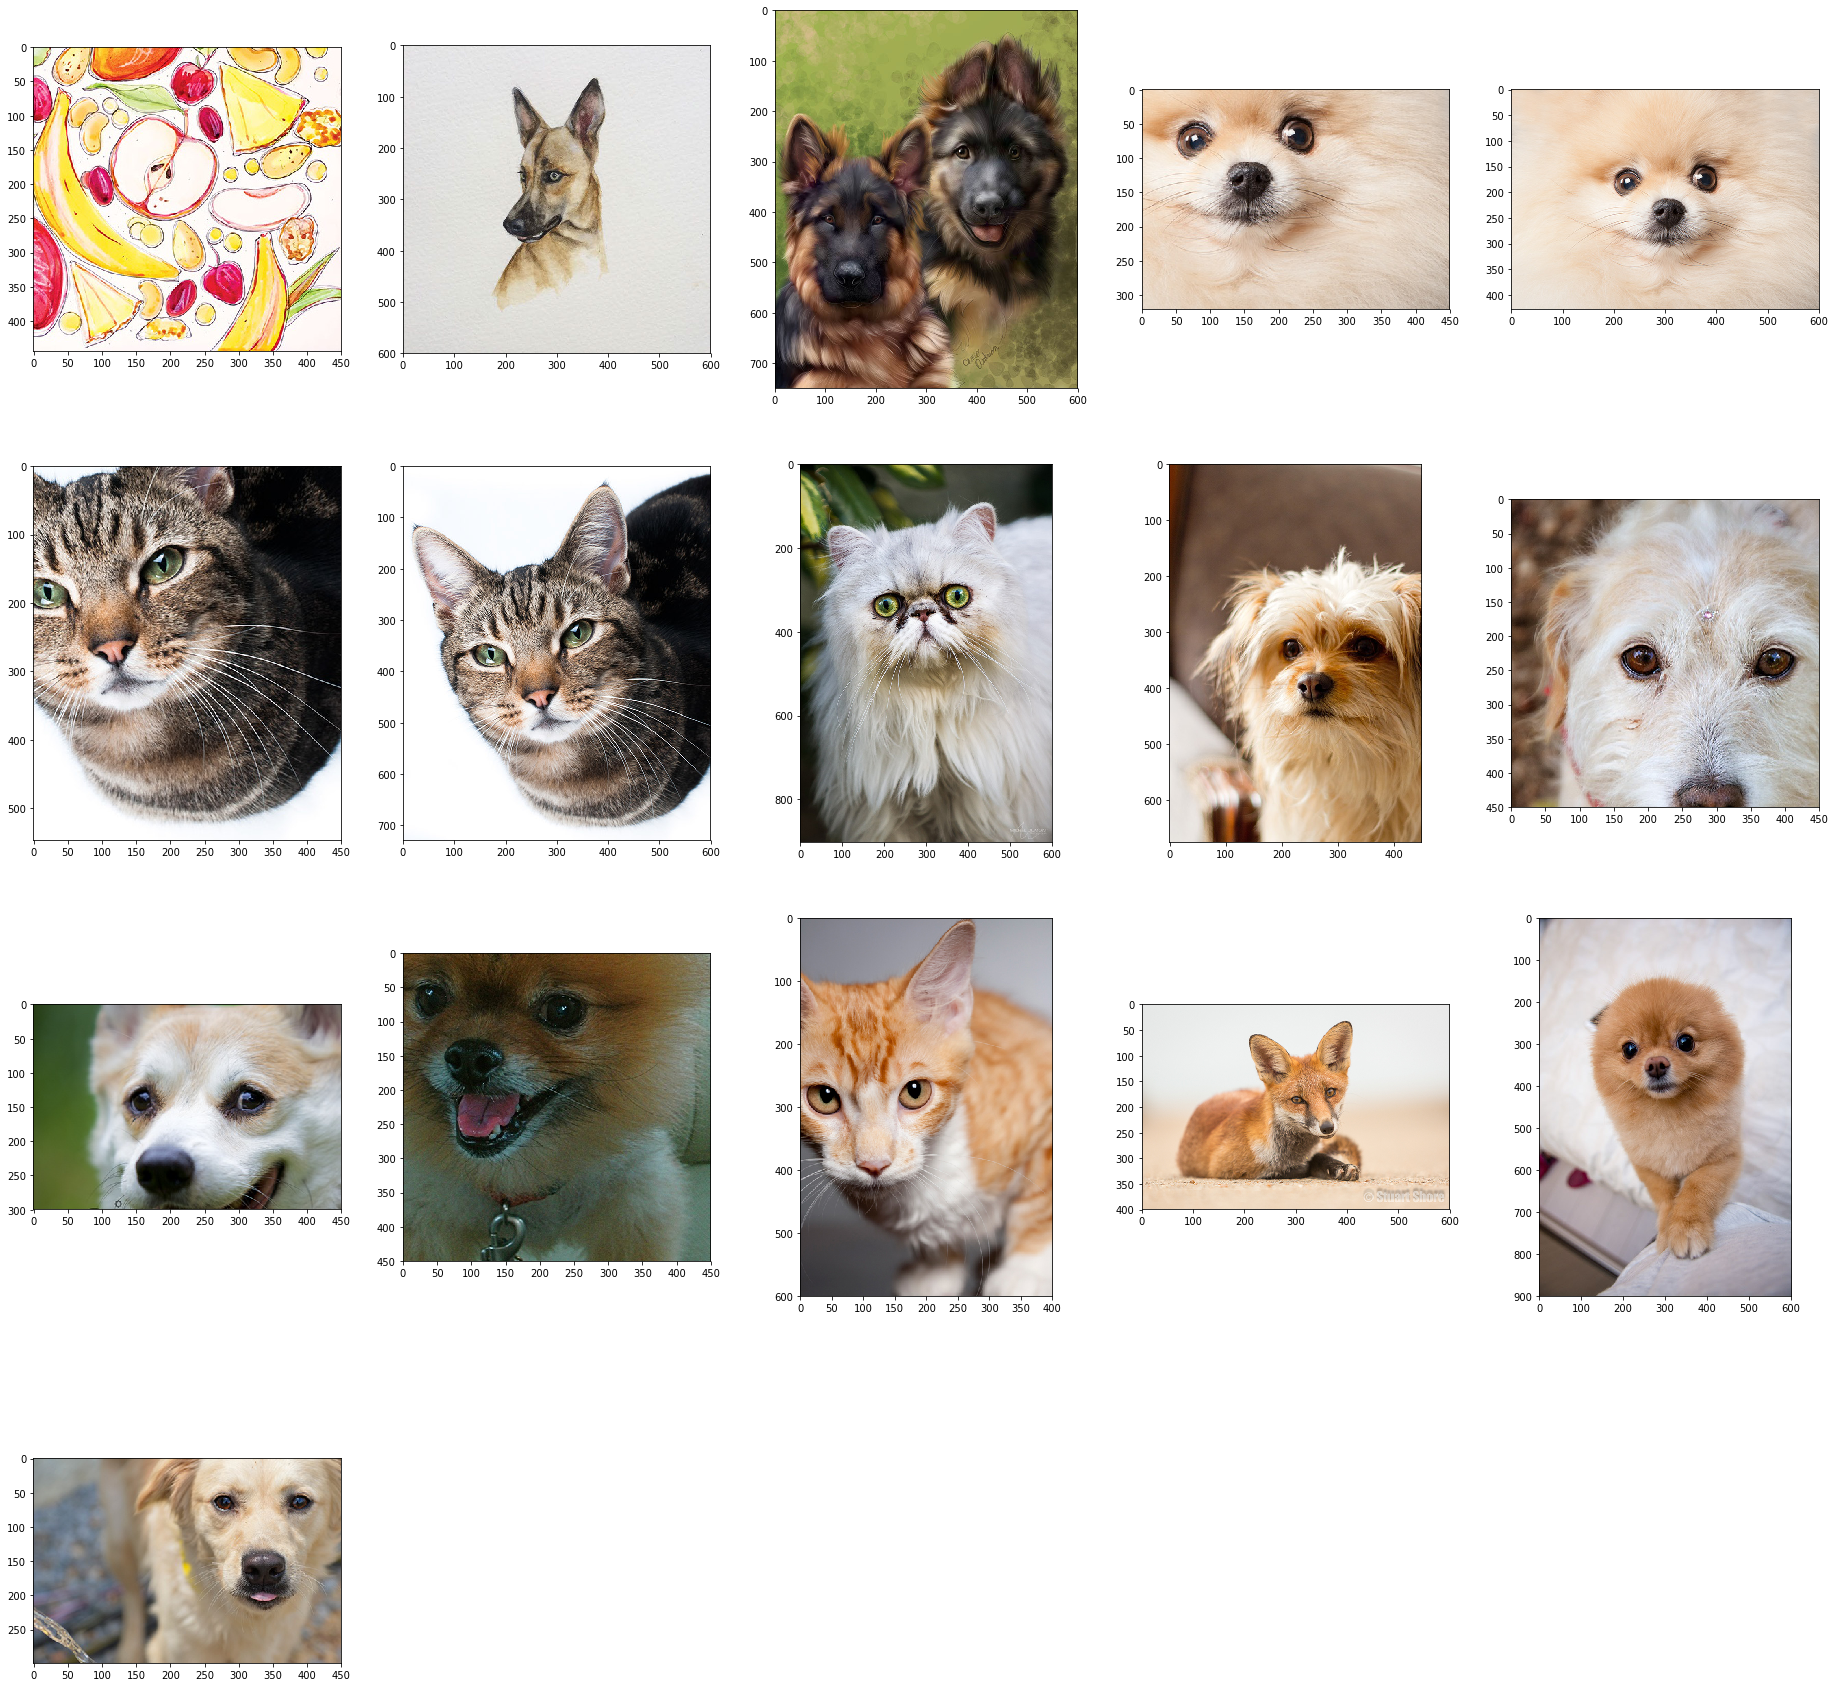

In [63]:
showNeighbours()

In [ ]:
import pickle

labels = None
with open('../bam_2_0_image_style_labels.pkl', 'rb') as handle:
    labels = pickle.load(handle)

print(len(labels))

idx2 = 0

names = getNames('/scratch/bam_subset_2_0_top_neighbours/', shuffle=True)

def getTopAccuracy(n):
    total = 0
    correct = 0
    mini = 1000000
    worst = None
    for i in range(n):
        truth = labels[names[i].split('/')[-1].replace('.npy', '')]
        nbs = np.load(names[i])
#         print(truth)
        curr = 0
        l = []
        for nb in nbs:
            nb = nb.split('/')[-1]
            l.append(labels[nb])
            if truth == labels[nb]:
                curr += 1
#             print(labels[nb])
            total += 1
        if curr < mini:
            mini = curr
            worst = i
            actual = truth
            nb_labels = l
        correct += curr
    showNeighbours(worst)
    print(mini, " / 15 are correct neighbours")
    print("Actual label", actual)
    print("Neighbour labels: ", nb_labels)
    return str((correct / total) * 100) + " %"

In [ ]:
print(getTopAccuracy(1000))

In [ ]:
mini = 10000
maxi = -10000
for i, x in enumerate(X):
#     print(i, x)
#     print(min(x), max(x))
    mini = min(min(x), mini)
    maxi = max(max(x), maxi)
    if i == 1000:
        break
print(mini, maxi)
